<a href="https://colab.research.google.com/github/Maxlab/pytorch_learn/blob/master/Copy_of_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [0]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:35<00:00, 16.1MB/s]


In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [0]:
def load_image(img_path, max_size=400, shape=None):
    
    image = Image.open(img_path).convert('RGB')
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
 
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), 
                                             (0.5, 0.5, 0.5))])

    image = in_transform(image).unsqueeze(0)
    
    return image


In [0]:
content = load_image('Roses.jpg').to(device)
style = load_image('Colours.jpg').to(device)

tensor([[[[-0.2471, -0.2235, -0.2157,  ..., -0.3333, -0.3333, -0.3255],
          [-0.2314, -0.2078, -0.2078,  ..., -0.3176, -0.3255, -0.3255],
          [-0.2078, -0.2078, -0.2078,  ..., -0.3176, -0.3255, -0.3255],
          ...,
          [-0.7020, -0.7020, -0.7020,  ..., -0.5137, -0.5529, -0.5686],
          [-0.6941, -0.7020, -0.7098,  ..., -0.5294, -0.5608, -0.5765],
          [-0.6863, -0.7020, -0.7020,  ..., -0.5451, -0.5608, -0.5765]],

         [[-0.5059, -0.5137, -0.5059,  ..., -0.5451, -0.5529, -0.5451],
          [-0.4902, -0.4980, -0.4902,  ..., -0.5451, -0.5451, -0.5451],
          [-0.4980, -0.4902, -0.4824,  ..., -0.5451, -0.5451, -0.5451],
          ...,
          [-0.8588, -0.8588, -0.8588,  ..., -0.6784, -0.7020, -0.7176],
          [-0.8588, -0.8588, -0.8510,  ..., -0.6784, -0.7020, -0.7176],
          [-0.8667, -0.8510, -0.8510,  ..., -0.6863, -0.7020, -0.7255]],

         [[-0.7176, -0.7098, -0.7176,  ..., -0.7333, -0.7412, -0.7333],
          [-0.7255, -0.7255, -

In [0]:
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)

    return image

(-0.5, 710.5, 399.5, -0.5)

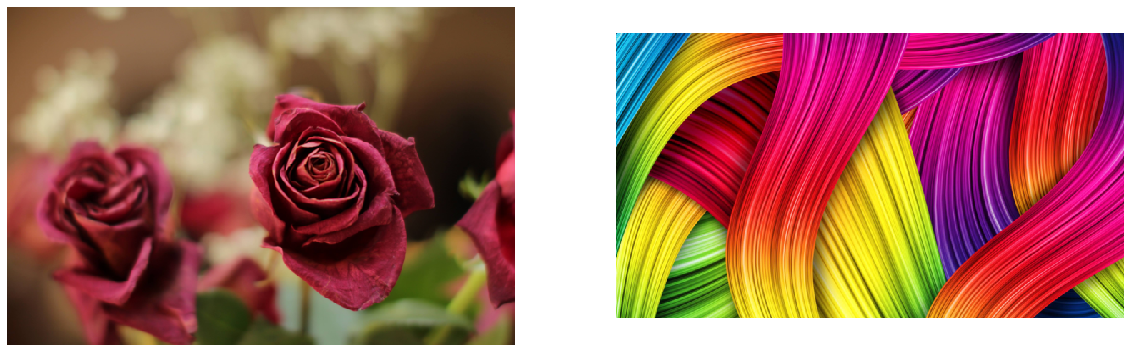

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis("off")
ax2.imshow(im_convert(style))
ax2.axis("off")

In [0]:
def get_features(image, model):
   
    layers = {'0': 'conv1_1',
              '5': 'conv2_1', 
              '10': 'conv3_1', 
              '19': 'conv4_1',
              '21': 'conv4_2',  # Content Extraction
              '28': 'conv5_1'}
        
    features = {}

    for name, layer in model._modules.items():
        image = layer(image)
        if name in layers:
            features[layers[name]] = image
            
    return features

In [0]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [0]:
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

In [0]:

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

In [0]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta


In [0]:
target = content.clone().requires_grad_(True).to(device)

In [0]:
show_every = 300
optimizer = optim.Adam([target], lr=0.003)
steps = 300

height, width, channels = im_convert(target).shape
image_array = np.empty(shape=(300, height, width, channels))
capture_frame = steps/300
counter = 0

Total loss:  45008880.0
Iteration:  300


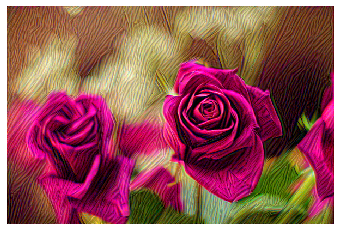

In [0]:
for ii in range(1, steps+1):
  target_features = get_features(target, vgg)
  content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
  style_loss = 0
  
  for layer in style_weights:
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    style_gram = style_grams[layer]
    layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
    _, d, h, w = target_feature.shape
    style_loss += layer_style_loss / (d * h * w)
  
  total_loss = content_weight * content_loss + style_weight * style_loss
  
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()
  
  if  ii % show_every == 0:
    print('Total loss: ', total_loss.item())
    print('Iteration: ', ii)
    plt.imshow(im_convert(target))
    plt.axis("off")
    plt.show()
    
  if ii % capture_frame == 0:
    image_array[counter] = im_convert(target)
    counter = counter + 1

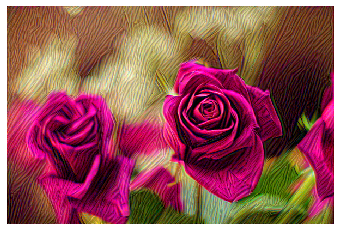

In [0]:
plt.imshow(im_convert(target))
plt.axis("off")
plt.show()

(-0.5, 599.5, 399.5, -0.5)

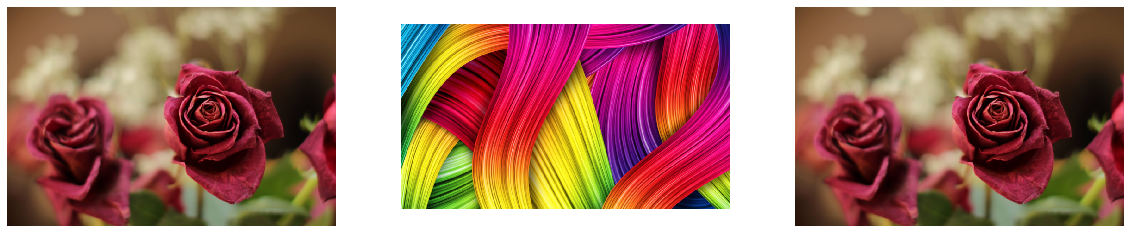

In [0]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')
ax3.imshow(im_convert(target))
ax3.axis('off')

In [0]:
import cv2 
frame_height, frame_width, _ = im_convert(target).shape
vid = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'XVID'), 30, (frame_width, frame_height))

for i in range(0, 300):
  img = image_array[i]
  img = img*255
  img = np.array(img, dtype = np.uint8)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  vid.write(img)

vid.release()

SyntaxError: ignored

In [0]:
!ls

In [0]:
from google.colab import files
files.download('output.mp4')